In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from scipy import stats

# Unzip NASLib/run/results/xgb_correlation.zip before running the code

In [2]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

def get_all_files(root_folder='../run/results/xgb_correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, train_size, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            info = json.load(f)

        config, scores = info[0], info[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'train_size': train_size,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        zc_names = config['zc_names']
        feature_importances = scores['zc_feature_importances']
        for zc_name in zc_names:
            record[f'{zc_name}_feat_imp'] = feature_importances[zc_name]

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['train_size', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'train_size')
    pivot_df.columns = pivot_df.columns.astype(int)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['train_size'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['train_size'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        train_sizes = tuple(df_['train_size'].to_list()) # List of predictor names

        all_corrs.append(compute_correlation(df_, train_sizes))

    corr = np.mean(np.array(all_corrs), axis=0)
    corr_df = pd.DataFrame(corr)

    train_sizes_map = {i: train_sizes[i] for i in range(len(train_sizes))}
    corr_df = corr_df.rename(columns=train_sizes_map, index=train_sizes_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'train_size'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_train_size_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'train_size'])[metric].mean()
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
    data = json.load(f)


In [6]:
files = get_all_files()

In [7]:
df = make_df(files)
df

,search_space,dataset,train_size,seed,kendalltau,pearson,spearman,preds,ground_truth,flops_feat_imp,...,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,epe_nas_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,nwot_feat_imp,synflow_feat_imp
0,nasbench301,cifar10,400,9004,0.396985,0.501891,0.566674,"[93.34323120117188, 93.9420166015625, 92.57710...","[93.99696266417807, 93.80230214466806, 92.7788...",298.0,...,168.0,356.0,236.0,269.0,614.0,412.0,282.0,175.0,207.0,255.0
1,nasbench301,cifar10,400,9006,0.439497,0.630892,0.630353,"[92.7950210571289, 92.70411682128906, 93.55503...","[93.6912163435105, 92.44779183570974, 93.26333...",323.0,...,205.0,326.0,255.0,285.0,633.0,378.0,321.0,193.0,221.0,278.0
2,nasbench301,cifar10,400,9008,0.378492,0.538563,0.538933,"[93.60047149658203, 91.8500747680664, 93.35445...","[93.50511843827208, 93.4491458115991, 93.59651...",314.0,...,193.0,258.0,271.0,313.0,654.0,387.0,327.0,170.0,229.0,264.0
3,nasbench301,cifar10,400,9002,0.407940,0.579155,0.582622,"[91.82305908203125, 92.89824676513672, 92.6096...","[93.36538381114971, 92.70637915468502, 93.0248...",318.0,...,226.0,317.0,228.0,330.0,642.0,383.0,345.0,173.0,178.0,299.0
4,nasbench301,cifar10,400,9001,0.407337,0.563164,0.576719,"[93.25755310058594, 93.90279388427734, 93.3186...","[93.61666350309224, 92.5360620889669, 93.03644...",301.0,...,166.0,333.0,228.0,332.0,651.0,407.0,329.0,162.0,180.0,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,transbench101_micro,normal,400,9000,0.646194,0.987270,0.818093,"[0.4974161982536316, 0.5519363284111023, 0.553...","[0.4939252734184265, 0.5599268674850464, 0.559...",281.0,...,178.0,351.0,250.0,264.0,NaN,533.0,312.0,282.0,271.0,NaN
176,transbench101_micro,normal,400,9005,0.631888,0.984954,0.808316,"[0.5477395057678223, 0.5071732401847839, 0.491...","[0.5324943661689758, 0.5045087337493896, 0.486...",320.0,...,134.0,327.0,218.0,297.0,NaN,608.0,349.0,282.0,282.0,NaN
177,transbench101_micro,normal,400,9007,0.674909,0.986002,0.851557,"[0.3388761579990387, 0.555773138999939, 0.5578...","[0.35744330286979675, 0.5392726063728333, 0.54...",324.0,...,196.0,395.0,243.0,265.0,NaN,547.0,297.0,234.0,255.0,NaN
178,transbench101_micro,normal,400,9003,0.651319,0.986554,0.825856,"[0.55991530418396, 0.5614558458328247, 0.54761...","[0.5565953850746155, 0.5700920224189758, 0.543...",331.0,...,165.0,322.0,253.0,315.0,NaN,561.0,329.0,276.0,236.0,NaN


In [8]:
def get_metrics(df, search_space, dataset, train_size, metric):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == str(train_size)) & (df['dataset'] == dataset)]
    return df_[metric].tolist()

def get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric):
    results = []

    for train_size in train_sizes:
        results.append(get_metrics(df, search_space, dataset, train_size, metric))

    results = np.array(results)
    means = np.mean(results, axis=1)
    stds = np.std(results, axis=1)
    
    return means, stds

def plot_line_chart(x_labels, means, stds, color, title='', ylabel=''):
    figsize=(16, 8)
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_labels, means, color=color)
    plt.fill_between(x_labels, means + stds, means - stds, color=color, alpha=0.2)
    plt.xscale('log', base=10)
    plt.xlabel('Train size')
    plt.ylabel(ylabel)

def plot_train_sizes_vs_metric(df, search_space, dataset, train_sizes, metric, color='gray'):
    means, stds = get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric)
    plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')


In [16]:
# train_sizes = [10, 16, 27, 46, 77, 129, 215, 359, 599]
# train_sizes = [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]
train_sizes = [400]

#df = make_df(files)
#plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'kendalltau', color='green')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'kendalltau', color='blue')

In [10]:
def get_mean_grouped_by(df, search_space, dataset, train_size):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == train_size) & (df['dataset'] == dataset)]
    return df_.groupby(['search_space', 'dataset', 'train_size'], as_index=False).mean()

def get_averaged_df(df, search_space, train_sizes):
    dfs = []

    for dataset in BENCHMARKS[search_space]:
        for train_size in train_sizes:
            dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
    return pd.concat(dfs)

def get_feature_importance_df(df, search_space, train_size):
    avg_df = get_averaged_df(df, search_space, train_sizes)
    feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
    avg_df = avg_df[avg_df['train_size'] == train_size].set_index('dataset')[feat_imp_cols]
    return avg_df

def plot_feature_importance_heatmap(df, search_space, train_size):
    avg_df = get_feature_importance_df(df, search_space, str(train_size))
    
    if search_space == 'transbench101_micro' or search_space == 'transbench101_macro':
        avg_df = avg_df.drop(columns=['epe_nas_feat_imp', 'synflow_feat_imp'])
    plot_heatmap(avg_df, rotation=45, title=f'{search_space}. Train size: {train_size}')

In [27]:
avg_df_nb201 = get_averaged_df(df, 'nasbench201', train_sizes)
avg_df_nb301 = get_averaged_df(df, 'nasbench301', train_sizes)
avg_df_tnb_micro = get_averaged_df(df, 'transbench101_micro', train_sizes)
avg_df_tnb_macro = get_averaged_df(df, 'transbench101_macro', train_sizes)
avg_df = pd.concat([avg_df_nb201, avg_df_nb301, avg_df_tnb_micro, avg_df_tnb_macro], axis=0)
avg_df

,search_space,dataset,train_size,kendalltau,pearson,spearman,flops_feat_imp,params_feat_imp,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,epe_nas_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,nwot_feat_imp,synflow_feat_imp
0,nasbench201,cifar10,400,0.794351,0.900577,0.941357,177.9,1.8,138.1,248.8,191.2,226.5,483.4,314.8,234.2,193.4,187.5,229.0
0,nasbench201,cifar100,400,0.794313,0.928693,0.939430,194.8,1.0,133.6,282.1,198.0,241.1,514.3,314.1,214.3,206.8,169.0,242.0
0,nasbench201,ImageNet16-120,400,0.787645,0.930469,0.930883,224.7,1.9,130.6,294.4,180.9,268.7,543.5,350.7,229.6,222.3,209.1,246.1
0,nasbench301,cifar10,400,0.408583,0.584772,0.582183,307.5,123.0,191.3,327.9,251.3,297.3,638.1,402.6,317.0,176.7,201.1,272.3
0,transbench101_micro,jigsaw,400,0.621517,0.953487,0.798086,272.5,26.1,142.2,325.2,183.6,312.2,NaN,538.9,311.8,236.6,235.5,NaN
0,transbench101_micro,class_scene,400,0.696646,0.977248,0.865789,247.7,25.8,104.0,298.9,179.5,248.8,NaN,499.3,295.7,234.0,227.8,NaN
0,transbench101_micro,class_object,400,0.651867,0.966484,0.820794,314.4,30.4,131.0,369.9,220.2,297.7,NaN,608.0,368.8,292.5,278.1,NaN
0,transbench101_micro,autoencoder,400,0.632151,0.955618,0.819253,311.0,29.5,186.3,379.5,284.2,325.5,NaN,669.5,355.3,308.5,278.9,NaN
0,transbench101_micro,normal,400,0.673175,0.984919,0.844197,315.9,26.4,172.8,338.6,247.0,279.8,NaN,559.5,313.0,258.9,258.4,NaN
0,transbench101_micro,room_layout,400,0.703266,0.962807,0.866429,305.1,31.8,145.4,375.7,227.4,288.1,NaN,651.4,347.2,284.5,290.9,NaN


In [28]:
feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
feat_imp_cols

['flops_feat_imp',
 'params_feat_imp',
 'snip_feat_imp',
 'jacov_feat_imp',
 'grad_norm_feat_imp',
 'plain_feat_imp',
 'epe_nas_feat_imp',
 'fisher_feat_imp',
 'grasp_feat_imp',
 'l2_norm_feat_imp',
 'nwot_feat_imp',
 'synflow_feat_imp']

In [29]:
df = make_df(files)

In [ ]:
plot_feature_importance_heatmap(df, search_space, train_size=train_size)

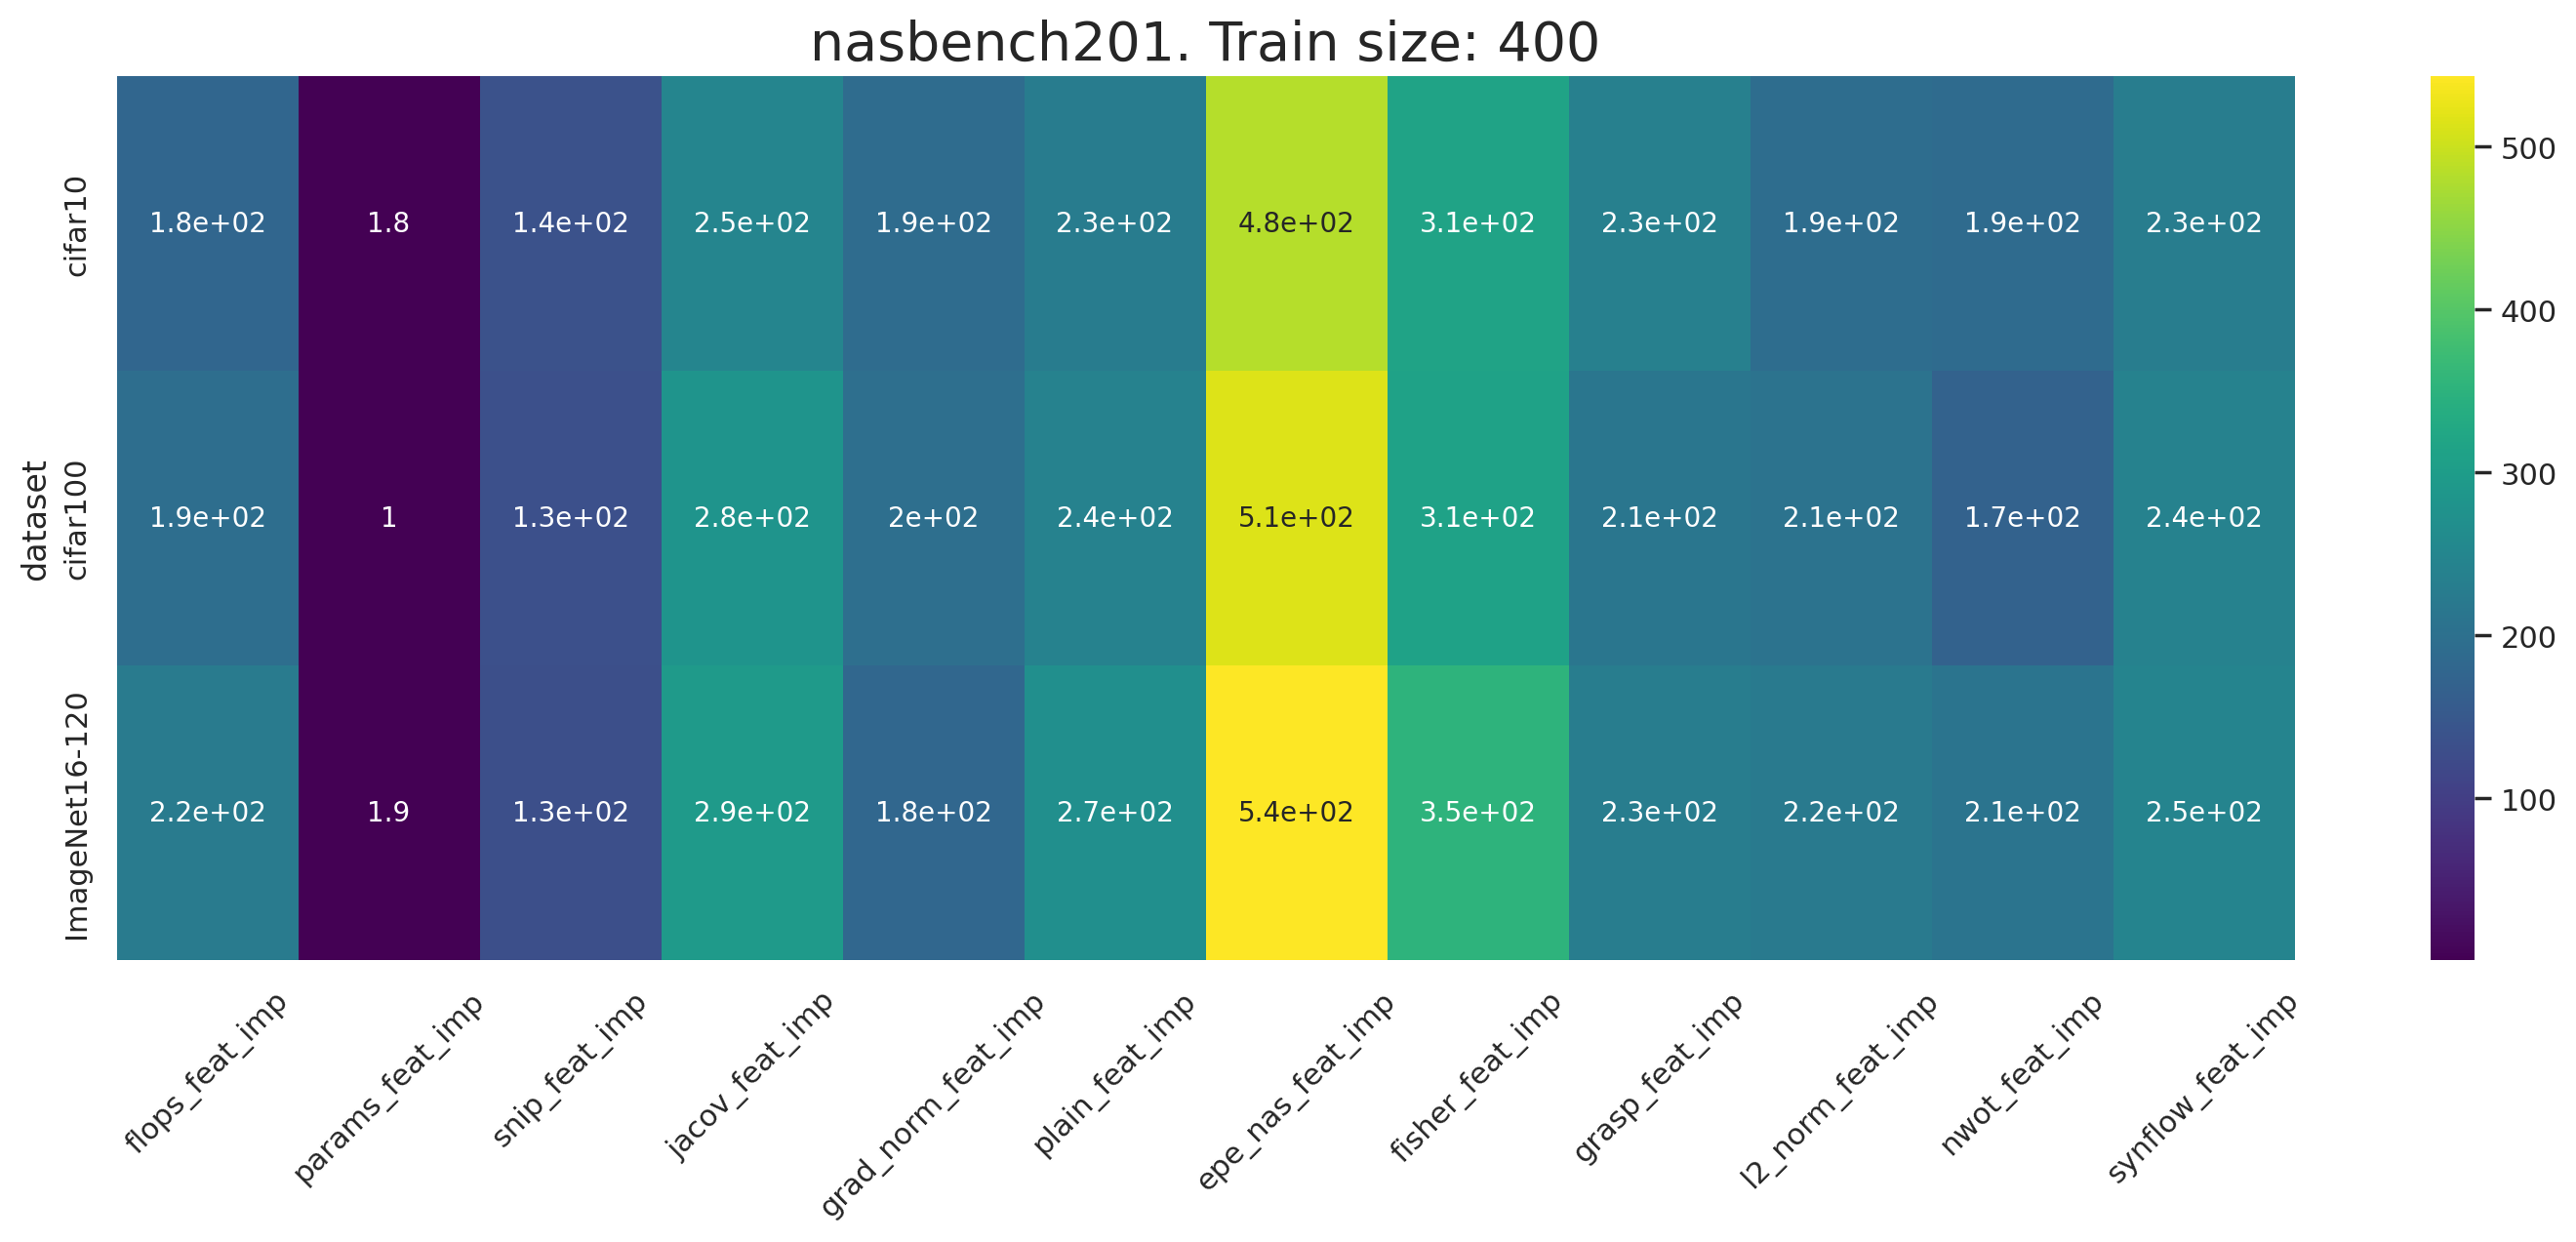

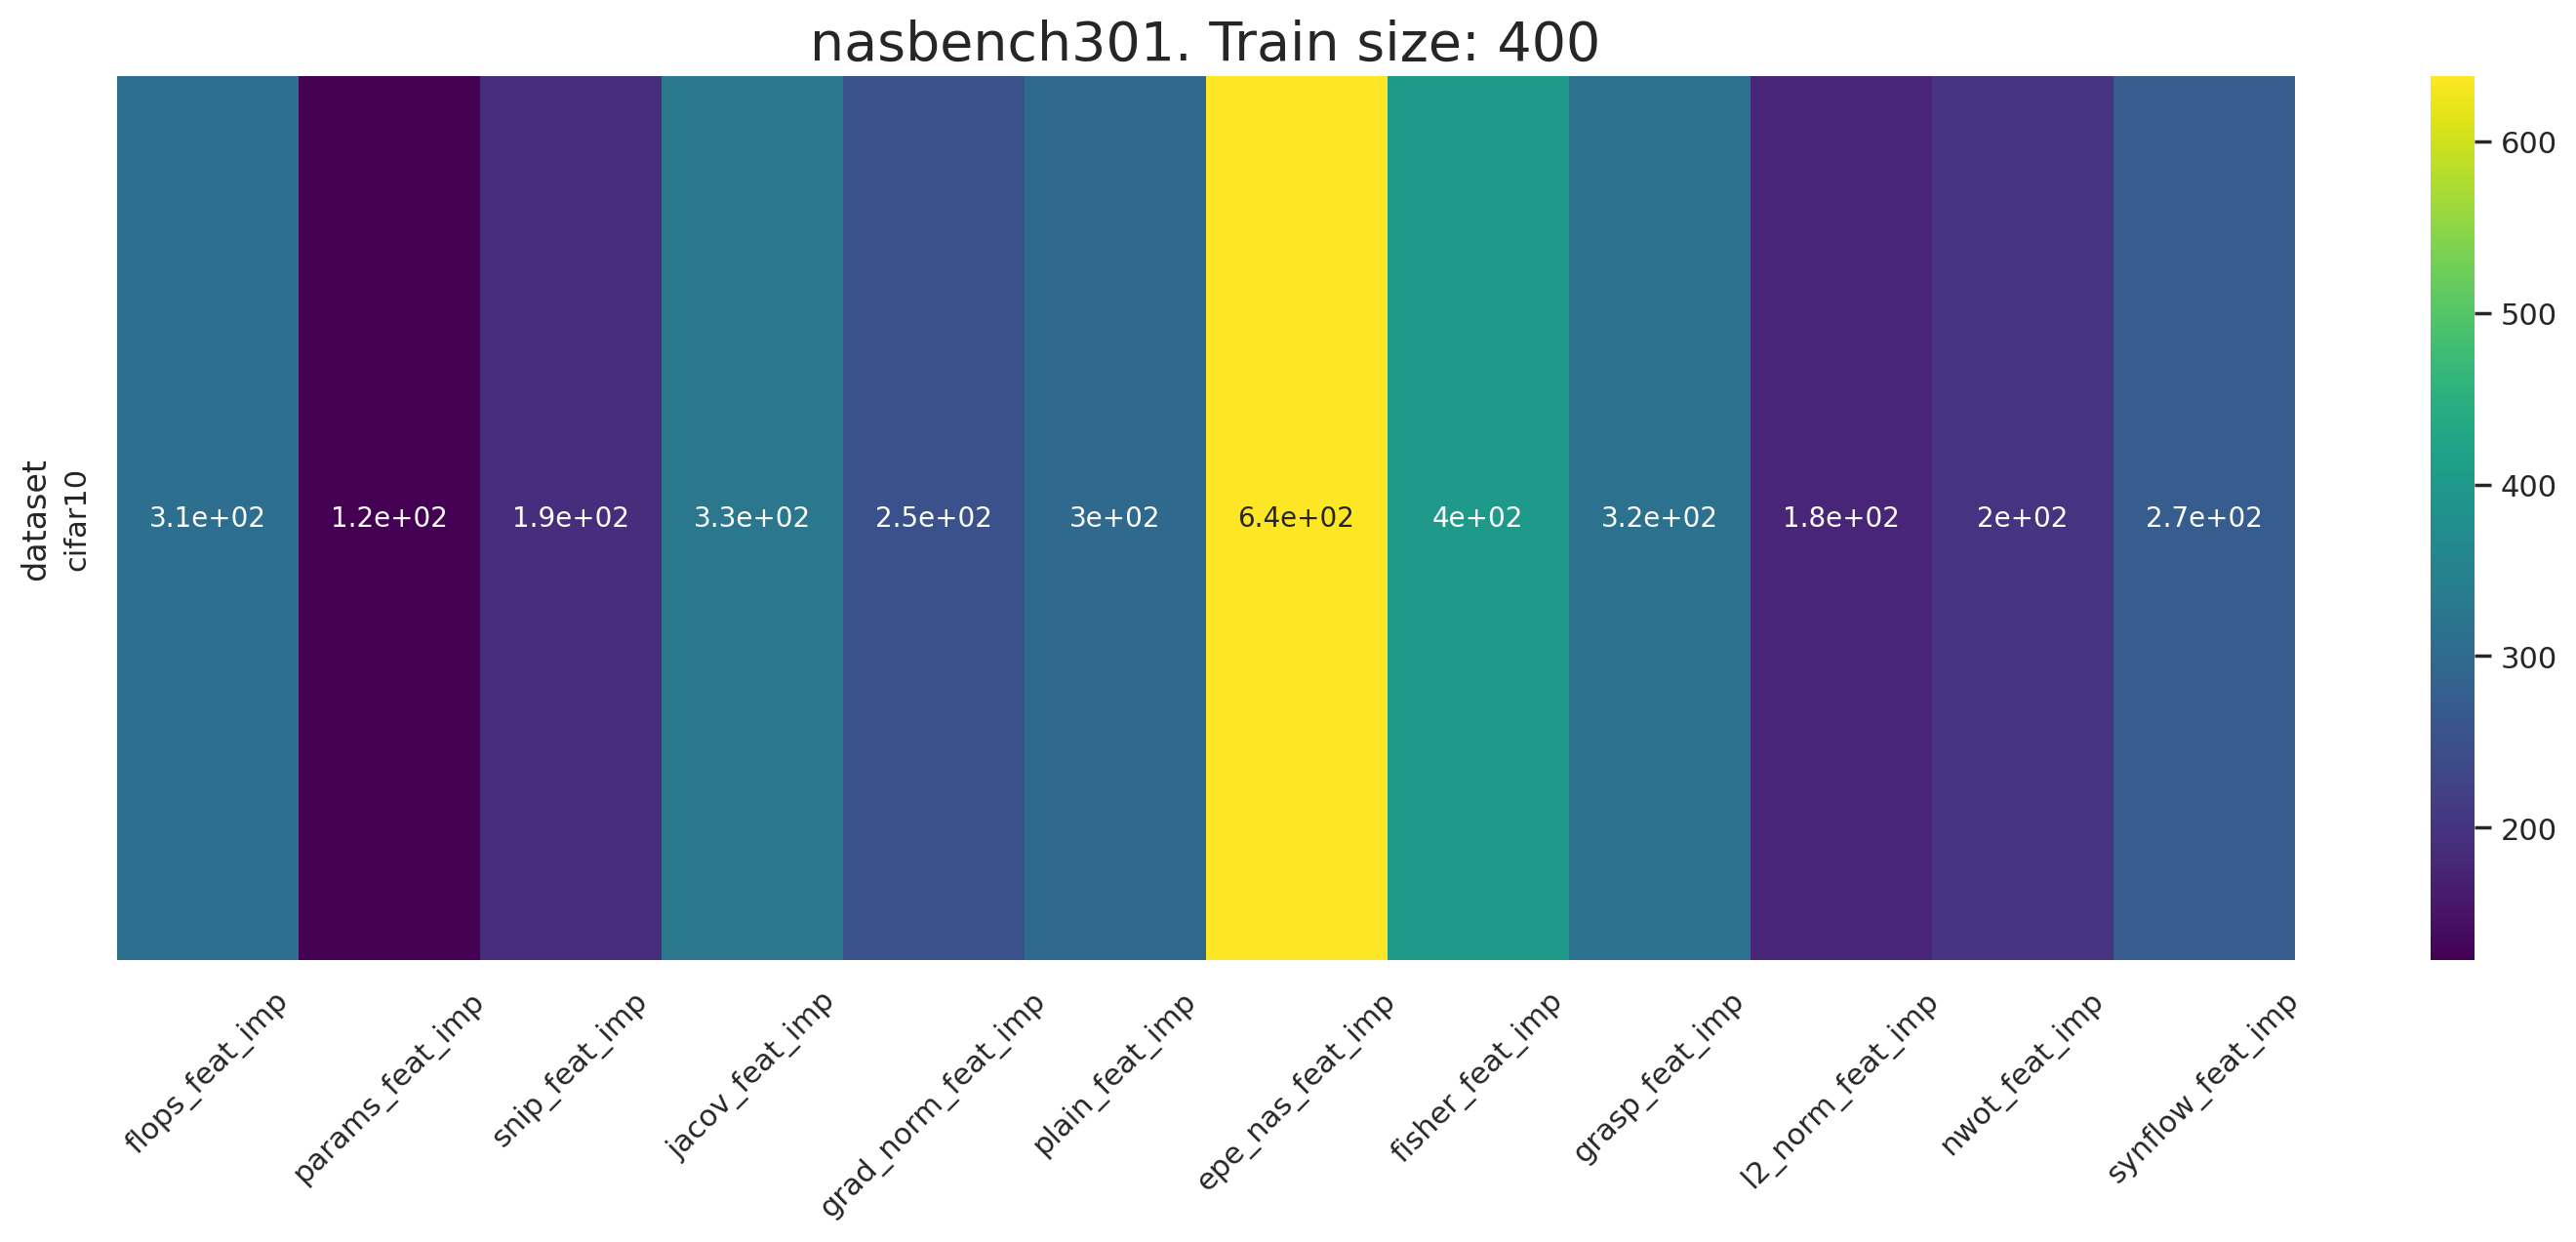

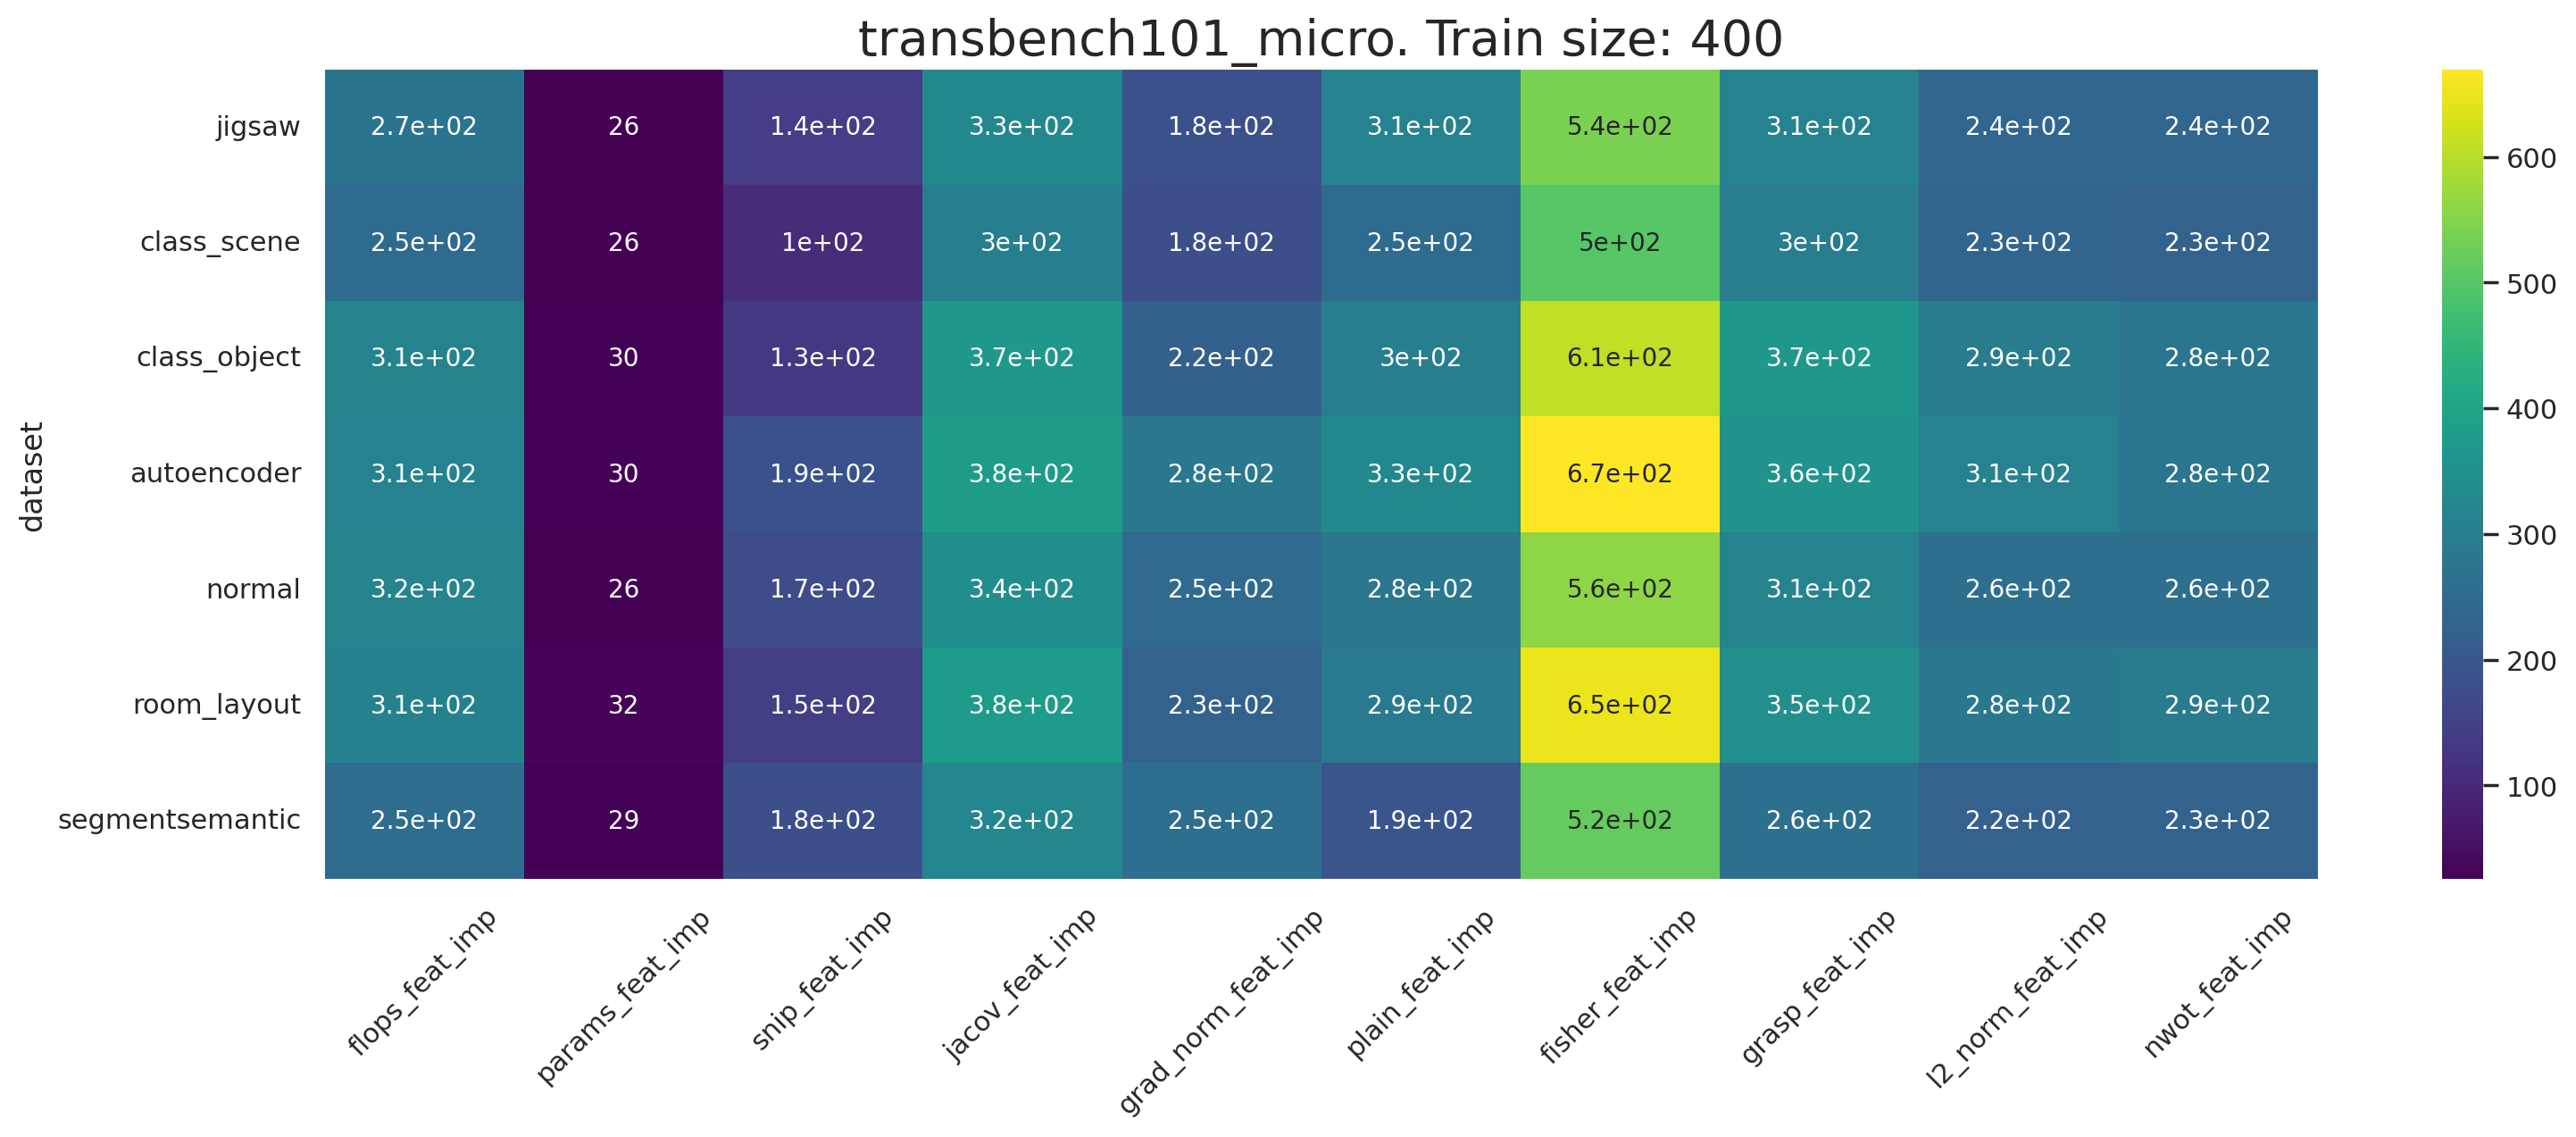

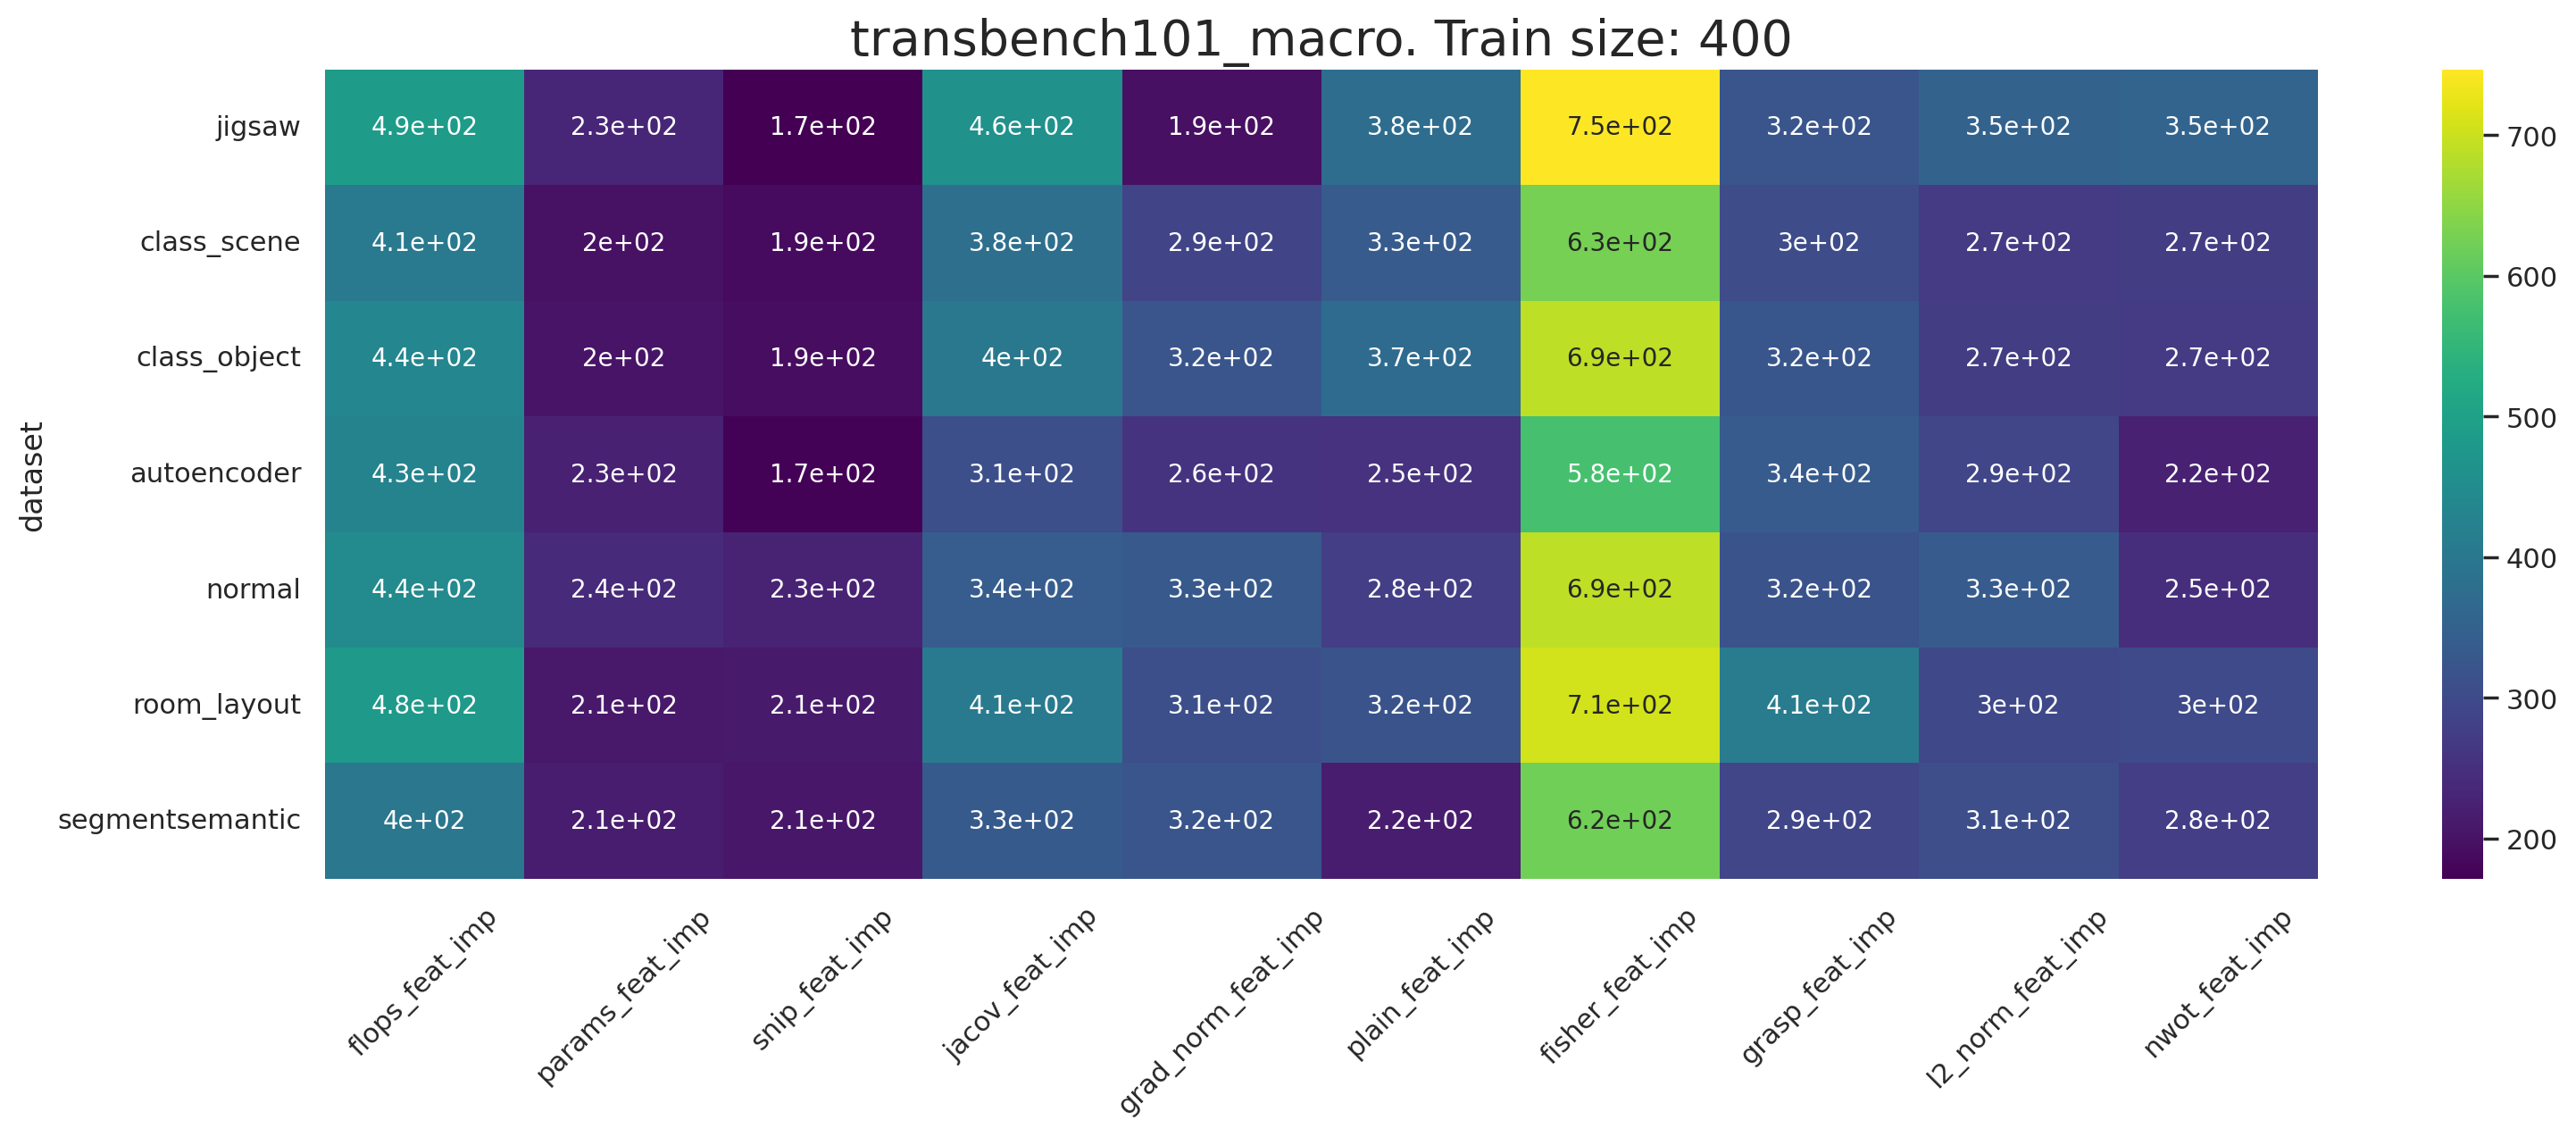

In [14]:
for search_space in BENCHMARKS.keys():
    for train_size in train_sizes:
        plot_feature_importance_heatmap(df, search_space, train_size=train_size)


In [14]:
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes[:7], 'spearman', color='grey')